# Batch process DroneScape LiDAR data into canopy height

* Catalog: https://data.tern.org.au/uas/dronescape/catalog.json
* Map viewer: https://maps.tern.org.au/map/6f06238f-8fbf-4306-8131-3b74729e1fc4

TERN UAV Dronescape data structure:

        Each dataset is structured as follows:
        PlotID/ 
        └── YYYYMMDD/ (Visit date in year-month-day format) 
          ├── imagery/ 
          │  ├── rgb/ 
          │  │  ├── level0_raw/ (DJI P1 raw imagery) 
          │  │  └── level1_proc/ (RGB orthomosaic as cloud-optimized GeoTIFF) 
          │  └── multispec/ 
          │    ├── level0_raw/ (Micasense raw data in TIF format) 
          │    └── level1_proc/ (Multispectral orthomosaic as cloud-optimized GeoTIFF) 
          ├── lidar/ 
          │  ├── level0_raw/ (DJI L2 raw data) 
          │  └── level1_proc/ (Processed point clouds in LAS format) 
          ├── drtk/ (DJI D-RTK logs) 
          └── metadata/ (Flight mission files, logs, and site visit metadata)

⚠️ **Important:** To access data programmatically, you need to create an TERN API key: https://account.tern.org.au/

Once you created an api key, create a `.netrc` file in your home directory (`cd ~`, `vim .netrc`), then copy the following into the file, replacing `YOUR_REAL_API_KEY` with your key copied from https://account.tern.org.au/ 

        machine data.tern.org.au
            login apikey
            password YOUR_REAL_API_KEY

You can now stream data from `data.tern.org.au`

> Using `laspy`, which can't open remote .laz files, instead using `requests` library to transfer data.

In [1]:
# !pip install laspy
# !pip install laspy[laszip]

## Import packages

In [2]:
import os

import odc.geo
from pystac import Catalog
from odc.stac import load
from odc.geo import BoundingBox
from shapely.geometry import shape, box
from dateutil import parser
from datetime import datetime
import xarray as xr
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

from canopy_height import laz_to_canopy_height
from dea_tools.plotting import display_map

## Analysis Parameters

In [3]:
aoi_path = 'data/SA_penisula.geojson'
start_date = '2023-01-01'
end_date = '2025-09-30'
collection = 'lidar'
level = 'level1_proc'

## Set up bbox and date queries

In [4]:
gdf = gpd.read_file(aoi_path)
xmin, ymin, xmax, ymax = gdf.bounds.values[0]

bbox = BoundingBox(
    left=xmin,
    bottom=ymin,
    right=xmax,
    top=ymax,
    crs="EPSG:4326"
)

bbox_geom = box(*bbox)
start_date = datetime.strptime(start_date, "%Y-%m-%d")
end_date   = datetime.strptime(end_date, "%Y-%m-%d")

## Show location of AOI

In [5]:
bbox.explore()

## Connect to STAC catalog

And filter metadata based on level, collection, dates, and boundingbox.

We don't have an API so we have to search through the whole catalog and filter manually.

In [6]:
# Open static catalog
catalog = Catalog.from_file("https://data.tern.org.au/uas/dronescape/catalog.json")

# Get all items (recursive)
all_items = list(catalog.get_items(recursive=True))

# Walk items (doesn't have an API so can't search)
# collection
filtered_items = [
    item for item in all_items if item.collection_id == collection
] 

# levels
filtered_items = [item for item in filtered_items if item.id == level]

# date range
filtered_items = [
    item for item in filtered_items if start_date
    <= parser.isoparse(item.properties["datetime"]).replace(tzinfo=None)
    <= end_date
]  

# bounding box
filtered_items = [item for item in filtered_items
    if item.geometry and shape(item.geometry).intersects(bbox_geom)
]

print(f"Found {len(filtered_items)} items")

Found 16 items


## Plot locations of returned data

In [8]:
polys = {}
for i in filtered_items:
    name = list(i.assets.keys())[1][0:10]
    poly = shape(i.geometry).boundary.convex_hull
    polys[name] = poly.centroid

In [9]:
gdf = gpd.GeoDataFrame(
    {"plot_id": list(polys.keys())},
    geometry=list(polys.values()),
    crs="EPSG:4326"  # Set CRS if known
)

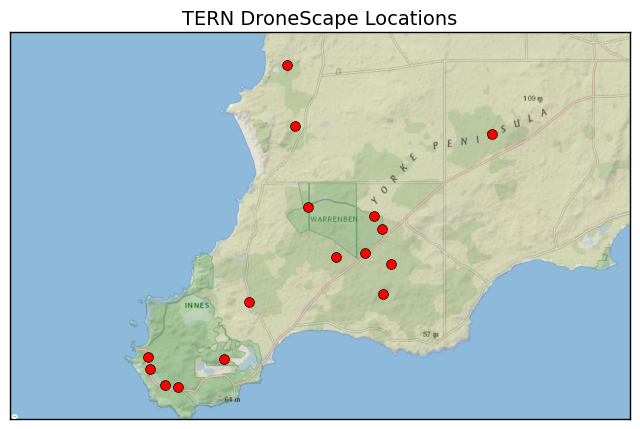

In [10]:
# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 8))

# Reproject to Web Mercator (required for contextily basemaps)
gdf_webmerc = gdf.to_crs(epsg=3857)

# Calculate bounds and add padding
xmin, ymin, xmax, ymax = gdf_webmerc.total_bounds
xpad = (xmax - xmin) * 0.4  # 30% padding
ypad = (ymax - ymin) * 0.1

# Plot points
gdf_webmerc.plot(
    ax=ax,
    # column='plot_id',
    color="red",
    markersize=50,
    edgecolor="black",
    linewidth=0.5,
    zorder=2,
)

# Set expanded limits before adding basemap
ax.set_xlim(xmin - xpad, xmax + xpad)
ax.set_ylim(ymin - ypad, ymax + ypad)

# Add basemap
ctx.add_basemap(ax, 
                source=ctx.providers.Esri.NatGeoWorldMap,
                attribution='ESRI',
                attribution_size=1)  # nice terrain map

# Clean up plot
# Add black border around axis
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1)

# Clean up (but keep spines visible)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_axis_off()
ax.set_title("TERN DroneScape Locations", fontsize=14)
ax.margins(0.1)

### Get a list of all urls to .laz files

In [11]:
all_hrefs = []
for item in filtered_items:
    href = item.links[3].href
    href = href.replace('level1_proc.json', list(item.assets.keys())[1])
    all_hrefs.append(href)

## Download each file and process canopy height

Using the script `canopy_height.laz_to_canopy_height`

In [12]:
for i, url in enumerate(all_hrefs[83:], start=1):
    
    print(f"Processing {i}/{len(all_hrefs)}...")
    
    name = url.split('/')[-1].split('.')[0]
    
    if os.path.exists(f"results/chm_tifs/{name}.tif"):
        continue
    else:
        print('  Site:', name)
        laz_to_canopy_height(url, save_tif=f"results/chm_tifs/{name}.tif")

## Plot

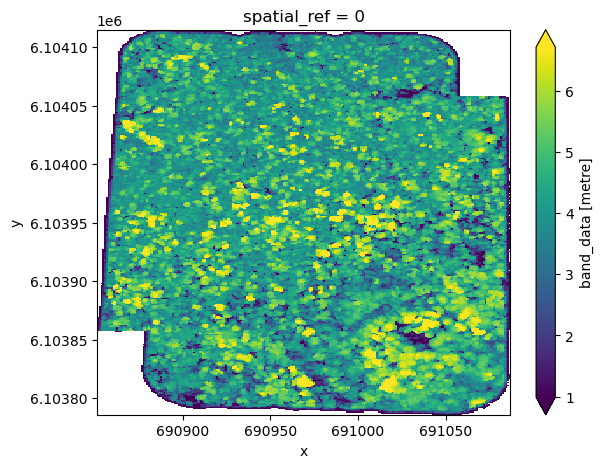

In [13]:
ds = xr.open_dataarray(f"results/chm_tifs/SAAEYB0013_20240718.tif").squeeze().drop_vars('band')
ds.plot.imshow(robust=True, size=5);

In [14]:
ds.odc.explore(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr = 'Esri',
    name = 'Esri Satellite',
    vmin=0, vmax=7
)